# Isochrones Ground Truth Plots

7/15/2023

Plan:
- Plot what the isochrones look like for the 3 datasets
- Plot isochrones with each trained model

In [1]:
import os
import numpy as np
import h5py
from collections import defaultdict
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torchsummary import summary

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using Torch version: %s' % (torch.__version__))
print('Using a %s device' % (device))

model_dir = 'models/'
data_dir = 'datasets/'
figure_dir = 'figures/'

label_keys = ['teff', 'feh', 'logg', 'alpha']
datasets = ['synth_clean', 'synth_noised', 'obs_GAIA', 'obs_APOGEE']


Using Torch version: 1.13.1+cu117
Using a cuda device


## Datasets and Dataloader

In [2]:
class SimpleSpectraDataset(torch.utils.data.Dataset):
    
    """
    Dataset loader for the simple spectral datasets.
    """

    def __init__(self, data_file, dataset, label_keys):
        
        self.data_file = data_file
        self.dataset = dataset.lower()
        self.label_keys = label_keys
        # Determine the number of pixels in each spectrum
        self.num_pixels = self.determine_num_pixels()
        self.num_spectra = self.determine_num_spectra()
                        
    def __len__(self):
        return self.num_spectra
    
    def determine_num_spectra(self):
        with h5py.File(self.data_file, "r") as f:    
            count = len(f['spectra %s' % self.dataset])
        return count
    
    def determine_num_pixels(self):
        with h5py.File(self.data_file, "r") as f:    
            pixels = f['spectra %s' % self.dataset].shape[1]
        return pixels
    
    def __getitem__(self, idx):
        
        with h5py.File(self.data_file, "r") as f: 
                
            # Load spectrum
            spectrum = f['spectra %s' % self.dataset][idx]
            spectrum[spectrum<-1] = -1.
            spectrum = torch.from_numpy(spectrum.astype(np.float32))
            
            # Load target stellar labels
            data_keys = f.keys()
            labels = []
            for k in self.label_keys:
                data_key = k + ' %s' % self.dataset
                if data_key in data_keys:
                    labels.append(f[data_key][idx])
                else:
                    labels.append(np.nan)
            labels = torch.from_numpy(np.asarray(labels).astype(np.float32))
            
        # Return full spectrum and target labels
        return {'spectrum':spectrum,
                'labels':labels}
    
def batch_to_device(batch, device):
    '''Convert a batch of samples to the desired device.'''
    for k in batch.keys():
        if isinstance(batch[k], list):
            for i in range(len(batch[k])):
                batch[k][i] = batch[k][i].to(device)
        else:
            try:
                batch[k] = batch[k].to(device)
            except AttributeError:
                batch[k] = torch.tensor(batch[k]).to(device)
    return batch

### Get Ground Truth Data

In [3]:
# Get validation data
batch_size = 16

val_datasets = {}
val_dataloaders = {}
for dataset in datasets:
    load_path = os.path.join(data_dir, dataset+'.h5')
    val_datasets[dataset] = SimpleSpectraDataset(load_path, 
                                       dataset='val', 
                                       label_keys=label_keys)

    val_dataloaders[dataset] = torch.utils.data.DataLoader(val_datasets[dataset],
                                                   batch_size=batch_size, 
                                                   shuffle=False, 
                                                   num_workers=1,
                                                   pin_memory=True)
    print("Created dataset for " + dataset + " with size " + str(len(val_datasets[dataset])))


ground_truth_labels = {}

print("Started extracting labels")
with torch.no_grad():
    for dataset in datasets:
        ground_truth_labels[dataset] = []
            
        current_dataloader = val_dataloaders[dataset]
        for val_batch in current_dataloader:

            # Save batch data for comparisons
            ground_truth_labels[dataset].append(val_batch['labels'].cpu().data.numpy())
        
        ground_truth_labels[dataset] = np.concatenate(ground_truth_labels[dataset])
        print("\tExtracted labels for " + dataset)
print("Done!")

Created dataset for synth_clean with size 3000
Created dataset for synth_noised with size 3000
Created dataset for obs_GAIA with size 3000
Created dataset for obs_APOGEE with size 3000
Started extracting labels
	Extracted labels for synth_clean
	Extracted labels for synth_noised
	Extracted labels for obs_GAIA
	Extracted labels for obs_APOGEE
Done!


### Plotting helper functions

In [4]:
def pretty(label):
    label_fancy = label
    
    if label=='teff':
        label_fancy = 'T$_{\mathrm{eff}}$ [K]'
    if label=='feh':
        label_fancy = '[Fe/H]'
    if label=='logg':
        label_fancy = 'log(g)'
    if label=='alpha':
        label_fancy = r'[$\alpha$/H]'
        
    if label=='synth_clean':
        label_fancy = 'Synthetic Data'
    if label=='synth_noised':
        label_fancy = 'Synthetic Data, Added Noise'
    if label=='obs_GAIA':
        label_fancy = 'Observed Data, GAIA Labels'
    if label=='obs_APOGEE':
        label_fancy = 'Observed Data, APOGEE Labels'
        
    return label_fancy

### Plot Isochrones

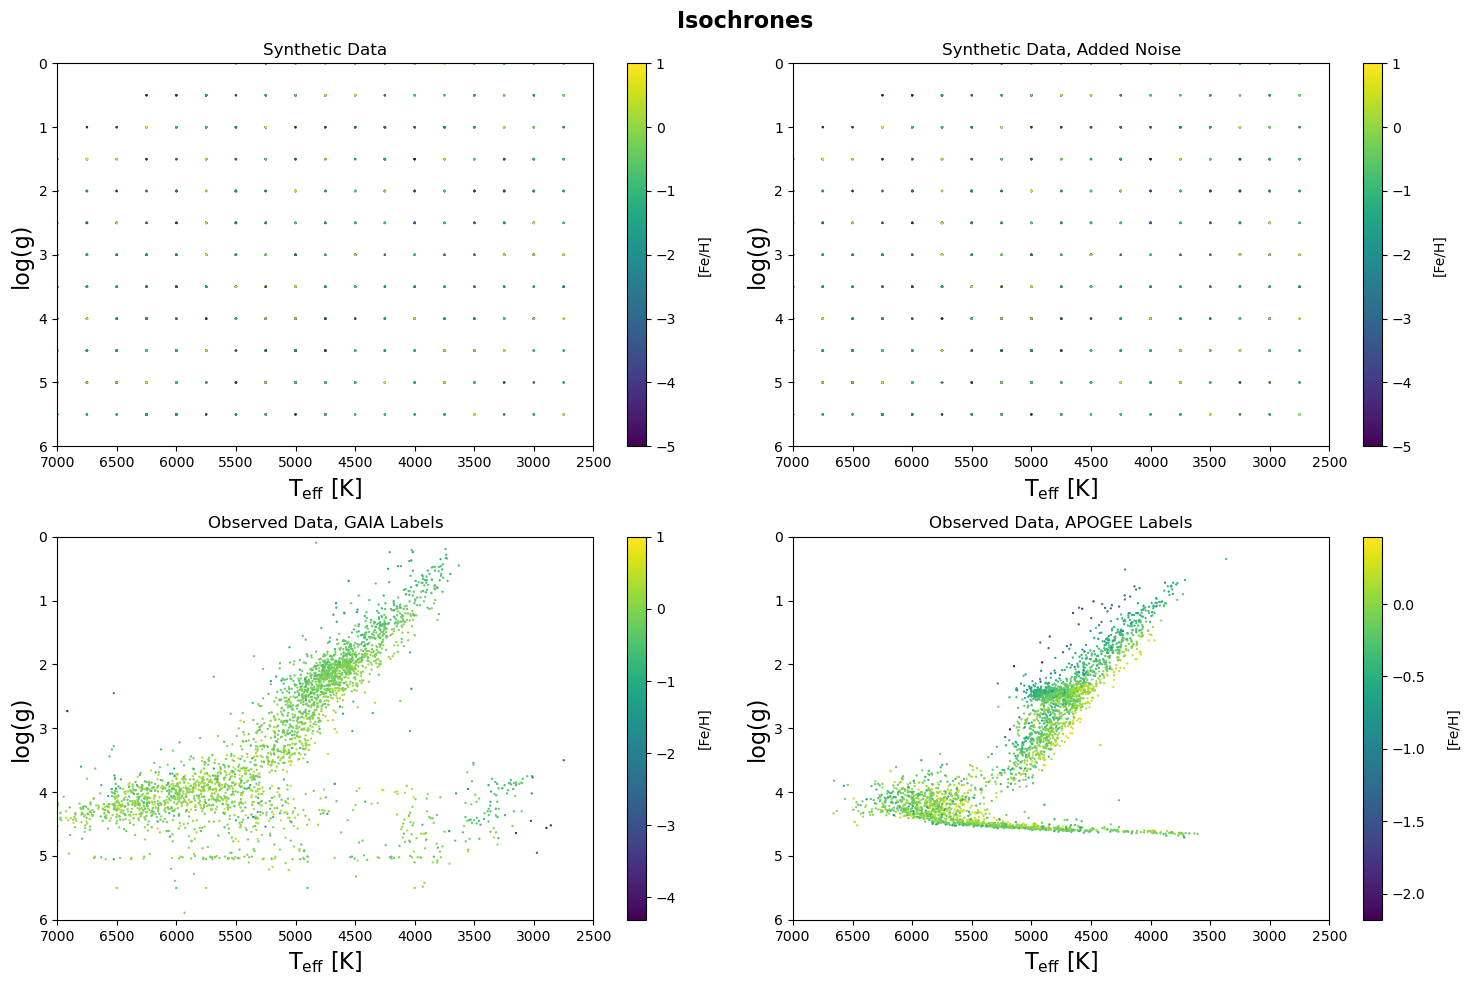

In [5]:
# Create the main figure and set the title
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Isochrones', fontsize=16, fontweight='bold')

# Iterate through the labels and create subplots
for j, dataset in enumerate(datasets):
    # Create a subplot in the 2x2 grid
    ax = fig.add_subplot(2, 2, j+1)
    
    # Create scatter plot on the given axes
    # log(g) on the y axis
    # Teff[K] on the x axis
    # Colorbar with Fe/H
    # label_keys = ['teff', 'feh', 'logg', 'alpha']
    # for example, ground_truth_labels[dataset][:,0] gets you all the teff values

    scatter = ax.scatter(ground_truth_labels[dataset][:,0], ground_truth_labels[dataset][:,2], c=ground_truth_labels[dataset][:,1], cmap='viridis', s=0.4)
    
    # Customize each subplot
    pretty_dataset = pretty(dataset)
    ax.set_title(pretty_dataset)
    ax.set_xlabel(pretty('teff'), size=4*len(label_keys))
    ax.set_ylabel(pretty('logg'), size=4*len(label_keys))

    # Show colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(pretty('feh'), rotation=90, labelpad=15)
    
    ax.set_ylim(6, 0)
    ax.set_xlim(7000, 2500)

# Adjust the spacing between subplots
fig.tight_layout()

# Save the figure
savename = figure_dir + 'GROUND_TRUTH' + '_isochrones.png'
plt.savefig(savename, facecolor='white', transparent=False, dpi=100,
            bbox_inches='tight', pad_inches=0.05)

# Show the figure
plt.show()